In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [2]:
import time

In [3]:
data_dir = r'C:/Users/stolb/Desktop/Материалы к лекциям/Deep Learning/simpsons/simpsons_dataset'
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_paths = [path.replace('\\', '/') for path in data_image_paths]
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [4]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.ElasticTransform(alpha = 250., sigma = 15.),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(180),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

FileNotFoundError: Found no valid file for the classes abraham_grampa_simpson, agnes_skinner, apu_nahasapeemapetilon, barney_gumble, bart_simpson, carl_carlson, charles_montgomery_burns, chief_wiggum, cletus_spuckler, comic_book_guy, disco_stu, edna_krabappel, fat_tony, gil, groundskeeper_willie, homer_simpson, kent_brockman, krusty_the_clown, lenny_leonard, lionel_hutz, lisa_simpson, maggie_simpson, marge_simpson, martin_prince, mayor_quimby, milhouse_van_houten, miss_hoover, moe_szyslak, ned_flanders, nelson_muntz, otto_mann, patty_bouvier, principal_skinner, professor_john_frink, rainier_wolfcastle, ralph_wiggum, selma_bouvier, sideshow_bob, sideshow_mel, snake_jailbird, troy_mcclure, waylon_smithers. 

In [8]:
v = []
for x in os.listdir(data_dir):
    print (x)
    break
    if x in val_files_path:
        v.append(x)

abraham_grampa_simpson


In [7]:
len(v)

0

In [14]:
len(train_dataset)

20933

In [16]:
len(val_dataset)

20933

In [17]:
data_dir

'C:/Users/stolb/Desktop/Материалы к лекциям/Deep Learning/simpsons/simpsons_dataset'

In [4]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [6]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

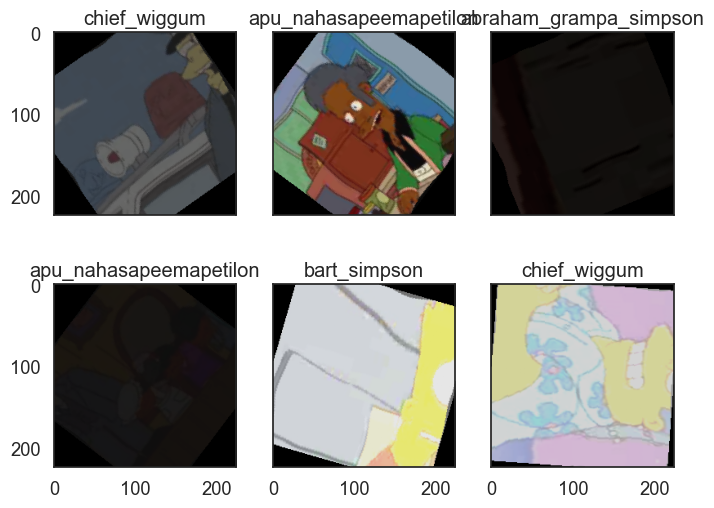

In [7]:
show_images(train_dataset)

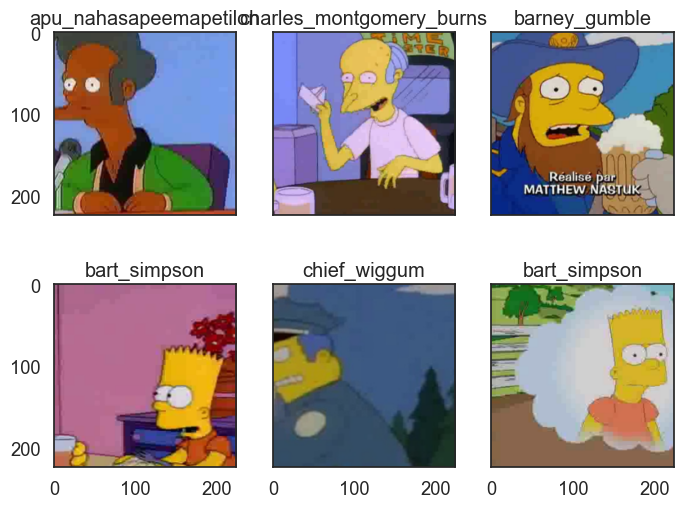

In [8]:
show_images(val_dataset)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
def train(
    net,
    trainer,
    train_iter,
    test_iter,
    num_epochs=10
):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [18]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [19]:
from torchvision.models import resnet18

In [21]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Step 0. time since epoch: 16.107. Train acc: 0.031. Train Loss: 3.734
Step 10. time since epoch: 191.263. Train acc: 0.078. Train Loss: 4.797
Step 20. time since epoch: 372.956. Train acc: 0.092. Train Loss: 4.124
Step 30. time since epoch: 567.648. Train acc: 0.086. Train Loss: 3.854
Step 40. time since epoch: 740.608. Train acc: 0.091. Train Loss: 3.706
Step 50. time since epoch: 915.756. Train acc: 0.085. Train Loss: 3.605
Step 60. time since epoch: 1104.704. Train acc: 0.089. Train Loss: 3.543
Step 70. time since epoch: 1287.560. Train acc: 0.090. Train Loss: 3.493
Step 80. time since epoch: 1470.472. Train acc: 0.090. Train Loss: 3.444
Step 90. time since epoch: 1657.300. Train acc: 0.093. Train Loss: 3.411
Step 100. time since epoch: 1844.988. Train acc: 0.096. Train Loss: 3.385
Step 110. time since epoch: 2027.266. Train acc: 0.098. Train Loss: 3.365
Step 120. time since epoch: 2205.390. Train acc: 0.099. Train Loss: 3.350
Step 130. time since epoch: 2391.443. Train acc: 0.099. 

KeyboardInterrupt: 